In [ ]:
# ## Methodology Overview

# This notebook analyzes the relationship between market sentiment (Fear/Greed)
# and trading performance using two datasets:

# - `historical_data.csv` (trade-level data from Hyperliquid)
# - `fear_greed_index.csv` (daily Bitcoin sentiment classifications)

# ### Key steps:
# 1. Load both datasets and clean date formats.
# 2. Merge trades with sentiment using the trade date.
# 3. Create useful features (Win Rate, ROI, Buy Ratio).
# 4. Analyze performance by mood, hour, and day of week.
# 5. Visualize results (bar charts, line charts).
# 6. Export summary results to `csv_files/` and save plots to `outputs/`.

# All code is written in Python using pandas, seaborn, and matplotlib.


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ds_Teerth_Purohit')


In [ ]:
import os

print("Current path:", os.getcwd())
print("Files in csv_files:", os.listdir('csv_files'))
print("Files in outputs:", os.listdir('outputs'))


Current path: /content/drive/MyDrive/Colab Notebooks/ds_Teerth_Purohit
Files in csv_files: ['fear_greed_index.csv', 'historical_data.csv', 'pnl_by_mood.csv', 'advanced_analysis_by_mood.csv', 'day_of_week_volume.csv', 'hourly_winrate.csv', 'side_performance.csv', 'top10_coin_pnl.csv']
Files in outputs: ['pnl_vs_mood.png', 'time_analysis.png', 'strategy_dashboard.png', 'psychology_check.png']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set(style="whitegrid")


In [ ]:
mood = pd.read_csv('csv_files/fear_greed_index.csv')
past_trades = pd.read_csv('csv_files/historical_data.csv')


In [ ]:
print("Mood data shape:", mood.shape)
print("Past trades data shape:", past_trades.shape)

print("\nMood columns:", mood.columns.tolist())
print("Trades columns:", past_trades.columns.tolist())

Mood data shape: (2644, 4)
Past trades data shape: (211224, 16)

Mood columns: ['timestamp', 'value', 'classification', 'date']
Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


In [ ]:
# Clean column names a bit (remove leading/trailing spaces)
past_trades.columns = past_trades.columns.str.strip()
mood.columns = mood.columns.str.strip()

# ---- Fix trade timestamp column ----
past_trades['Timestamp IST'] = pd.to_datetime(
    past_trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)


In [ ]:
past_trades['trade_date'] = past_trades['Timestamp IST'].dt.date

# Fix mood date
mood['date'] = pd.to_datetime(mood['date'], dayfirst=True, errors='coerce').dt.date

# ---- Merge on date: add mood to each trade ----
combined_data = pd.merge(
    past_trades,
    mood,
    left_on='trade_date',
    right_on='date',
    how='inner'
)

print("Combined data shape:", combined_data.shape)
combined_data.head()

Combined data shape: (35864, 21)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Order ID,Crossed,Fee,Trade ID,Timestamp,trade_date,timestamp,value,classification,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,1707715800,70,Greed,2024-12-02
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,1707715800,70,Greed,2024-12-02
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,1707715800,70,Greed,2024-12-02
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,1707715800,70,Greed,2024-12-02
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,1707715800,70,Greed,2024-12-02


Average Profit/Loss by Market Mood:
  classification  Closed PnL
0   Extreme Fear    1.891632
1  Extreme Greed  205.816345
2           Fear  128.287950
3          Greed   53.988003
4        Neutral   27.088803


/tmp/ipython-input-4062622907.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


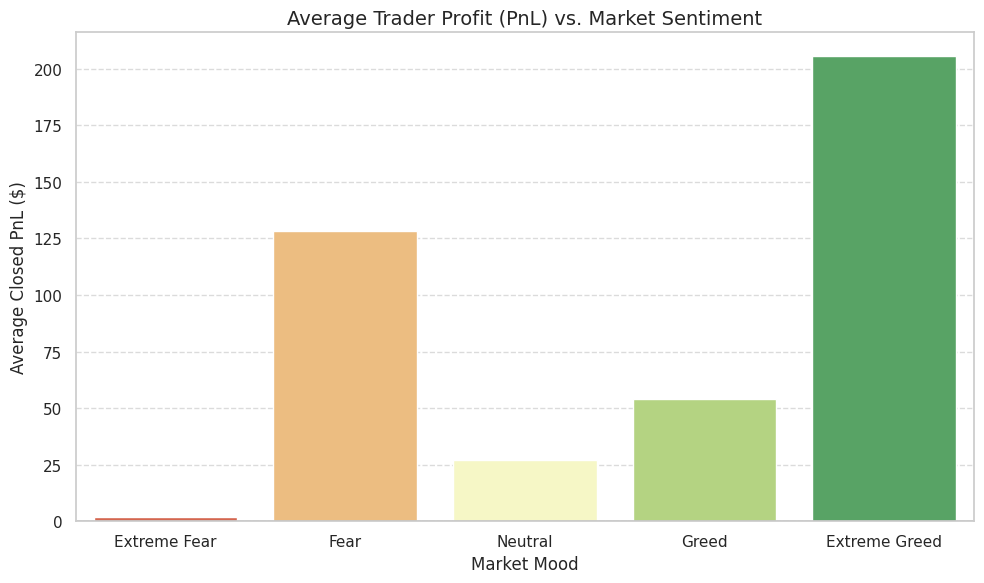

In [ ]:
# ============================
# 4. Average PnL by market mood
# ============================

pnl_by_mood = (
    combined_data
    .groupby('classification', as_index=False)['Closed PnL']
    .mean()
)

# Logical order of moods
mood_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
mood_order = [m for m in mood_order if m in pnl_by_mood['classification'].values]

print("Average Profit/Loss by Market Mood:")
print(pnl_by_mood)

# ---- Plot: Avg PnL vs Sentiment ----
plt.figure(figsize=(10, 6))
sns.barplot(
    data=pnl_by_mood,
    x='classification',
    y='Closed PnL',
    order=mood_order,
    palette='RdYlGn'
)
plt.title('Average Trader Profit (PnL) vs. Market Sentiment', fontsize=14)
plt.xlabel('Market Mood', fontsize=12)
plt.ylabel('Average Closed PnL ($)', fontsize=12)
plt.axhline(0, color='black', linewidth=1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('outputs/pnl_vs_mood.png')
plt.show()

# Save the summary as CSV
pnl_by_mood.to_csv('csv_files/pnl_by_mood.csv', index=False)

/tmp/ipython-input-2899951063.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


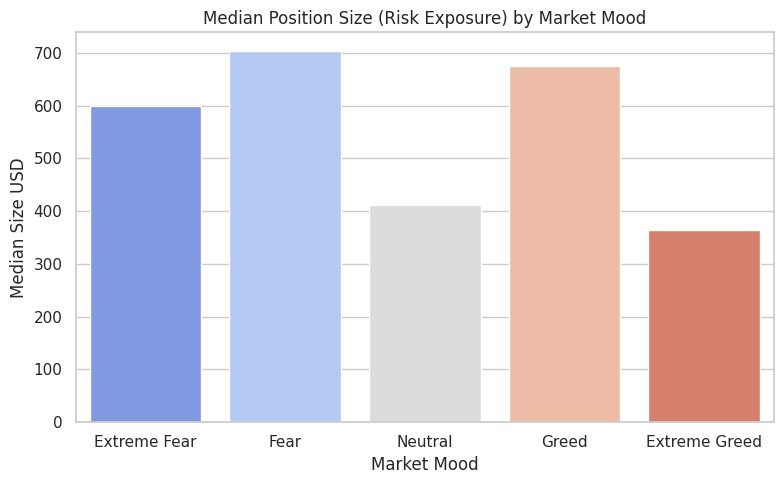

In [104]:
size_by_mood = (
    combined_data
    .groupby('classification')['Size USD']
    .median()
    .reindex(mood_order)
)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=size_by_mood.index,
    y=size_by_mood.values,
    palette='coolwarm'
)
plt.title('Median Position Size (Risk Exposure) by Market Mood')
plt.ylabel('Median Size USD')
plt.xlabel('Market Mood')
plt.tight_layout()
plt.savefig('outputs/leverage_proxy_size.png')
plt.show()


/tmp/ipython-input-357130102.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


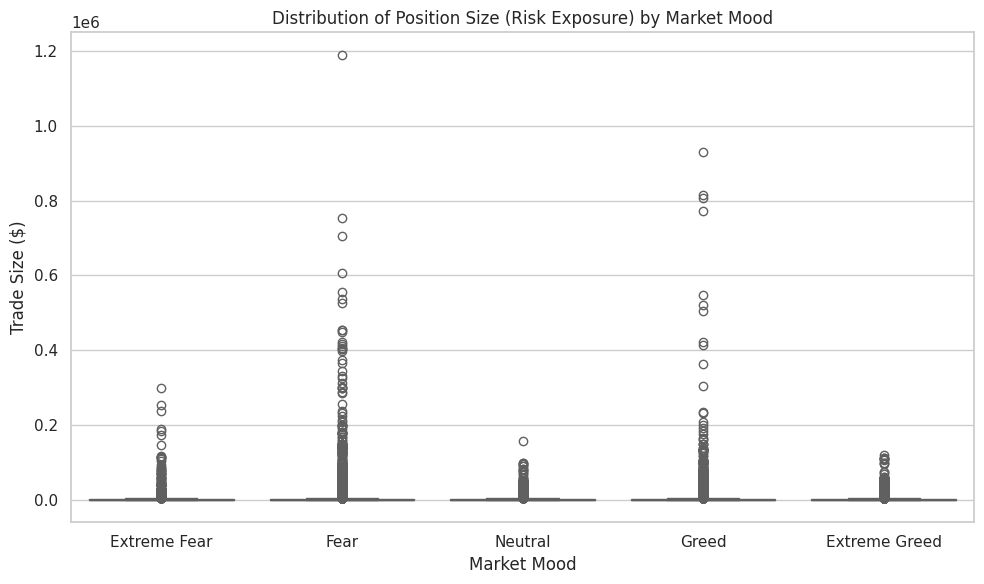

In [105]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='classification',
    y='Size USD',
    data=combined_data,
    order=mood_order,
    palette='coolwarm'
)
plt.title('Distribution of Position Size (Risk Exposure) by Market Mood')
plt.ylabel('Trade Size ($)')
plt.xlabel('Market Mood')
plt.tight_layout()
plt.savefig('outputs/leverage_boxplot.png')
plt.show()


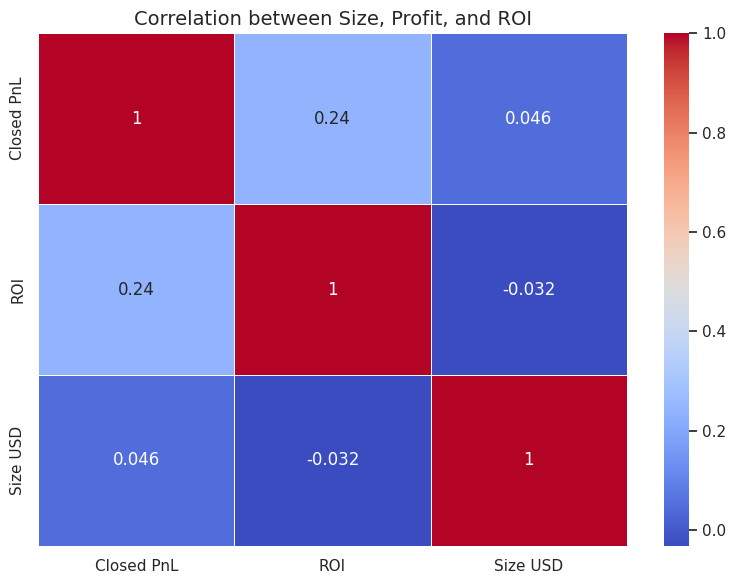

In [107]:
# Correlation heatmap: Size vs Profit vs ROI
corr = combined_data[['Closed PnL', 'ROI', 'Size USD']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Correlation between Size, Profit, and ROI', fontsize=14)

plt.tight_layout()
plt.savefig('outputs/correlation_heatmap.png', dpi=300)
plt.show()



In [ ]:
# Quick sanity check: merged data preview
print("Combined data shape:", combined_data.shape)
combined_data[['trade_date', 'classification', 'Closed PnL', 'Size USD', 'Side']].head()


Combined data shape: (35864, 21)


,trade_date,classification,Closed PnL,Size USD,Side
0,2024-12-02,Greed,0.0,7872.16,BUY
1,2024-12-02,Greed,0.0,127.68,BUY
2,2024-12-02,Greed,0.0,1150.63,BUY
3,2024-12-02,Greed,0.0,1142.04,BUY
4,2024-12-02,Greed,0.0,69.75,BUY


In [ ]:
# Add a simple win/loss flag
combined_data['is_win'] = combined_data['Closed PnL'] > 0

# Just to check:
combined_data[['Closed PnL', 'is_win']].head()


,Closed PnL,is_win
0,0.0,False
1,0.0,False
2,0.0,False
3,0.0,False
4,0.0,False


In [ ]:
# ROI (%) = profit / size * 100
def calculate_roi(row):
    if row['Size USD'] > 0:
        return (row['Closed PnL'] / row['Size USD']) * 100
    else:
        return 0

combined_data['ROI'] = combined_data.apply(calculate_roi, axis=1)

combined_data[['Closed PnL', 'Size USD', 'ROI']].head()


,Closed PnL,Size USD,ROI
0,0.0,7872.16,0.0
1,0.0,127.68,0.0
2,0.0,1150.63,0.0
3,0.0,1142.04,0.0
4,0.0,69.75,0.0


In [ ]:
# Group by market mood (classification) and calculate key stats
advanced_analysis = combined_data.groupby('classification').agg({
    'Closed PnL': 'mean',        # Average profit per trade
    'Size USD': 'mean',          # Average size (risk)
    'is_win': 'mean',            # Win rate
    'ROI': 'mean',               # Average ROI
    'Account': 'count'           # Number of trades
})

# Make the column names more readable
advanced_analysis = advanced_analysis.rename(columns={
    'Closed PnL': 'Avg PnL',
    'Size USD': 'Avg Volume',
    'is_win': 'Win Rate',
    'Account': 'Trade Count'
})

advanced_analysis


,Avg PnL,Avg Volume,Win Rate,ROI,Trade Count
classification,,,,,
Extreme Fear,1.891632,4118.761840,0.292777,0.318779,2326
Extreme Greed,205.816345,3242.085086,0.553282,13.493759,5621
Fear,128.287950,5744.782685,0.381787,2.980013,13869
Greed,53.988003,5051.878829,0.435707,3.045427,11292
Neutral,27.088803,4332.202906,0.494920,2.381389,2756


In [ ]:
# Buy ratio: out of all trades in that mood, how many were BUYs
buy_counts = combined_data[combined_data['Side'] == 'BUY'].groupby('classification')['Side'].count()
total_counts = combined_data.groupby('classification')['Side'].count()

advanced_analysis['Buy Ratio'] = buy_counts / total_counts

advanced_analysis


,Avg PnL,Avg Volume,Win Rate,ROI,Trade Count,Buy Ratio
classification,,,,,,
Extreme Fear,1.891632,4118.761840,0.292777,0.318779,2326,0.502150
Extreme Greed,205.816345,3242.085086,0.553282,13.493759,5621,0.295499
Fear,128.287950,5744.782685,0.381787,2.980013,13869,0.526858
Greed,53.988003,5051.878829,0.435707,3.045427,11292,0.478835
Neutral,27.088803,4332.202906,0.494920,2.381389,2756,0.370102


In [ ]:
# Keep moods in a logical order
mood_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
mood_order = [m for m in mood_order if m in advanced_analysis.index]

advanced_analysis = advanced_analysis.reindex(mood_order)

print("Advanced hidden trends table:")
print(advanced_analysis)

# Save this table as a processed CSV
advanced_analysis.to_csv('csv_files/advanced_analysis_by_mood.csv')


Advanced hidden trends table:
                   Avg PnL   Avg Volume  Win Rate        ROI  Trade Count  \
classification                                                              
Extreme Fear      1.891632  4118.761840  0.292777   0.318779         2326   
Fear            128.287950  5744.782685  0.381787   2.980013        13869   
Neutral          27.088803  4332.202906  0.494920   2.381389         2756   
Greed            53.988003  5051.878829  0.435707   3.045427        11292   
Extreme Greed   205.816345  3242.085086  0.553282  13.493759         5621   

                Buy Ratio  
classification             
Extreme Fear     0.502150  
Fear             0.526858  
Neutral          0.370102  
Greed            0.478835  
Extreme Greed    0.295499  


/tmp/ipython-input-954304827.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-954304827.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-954304827.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-954304827.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


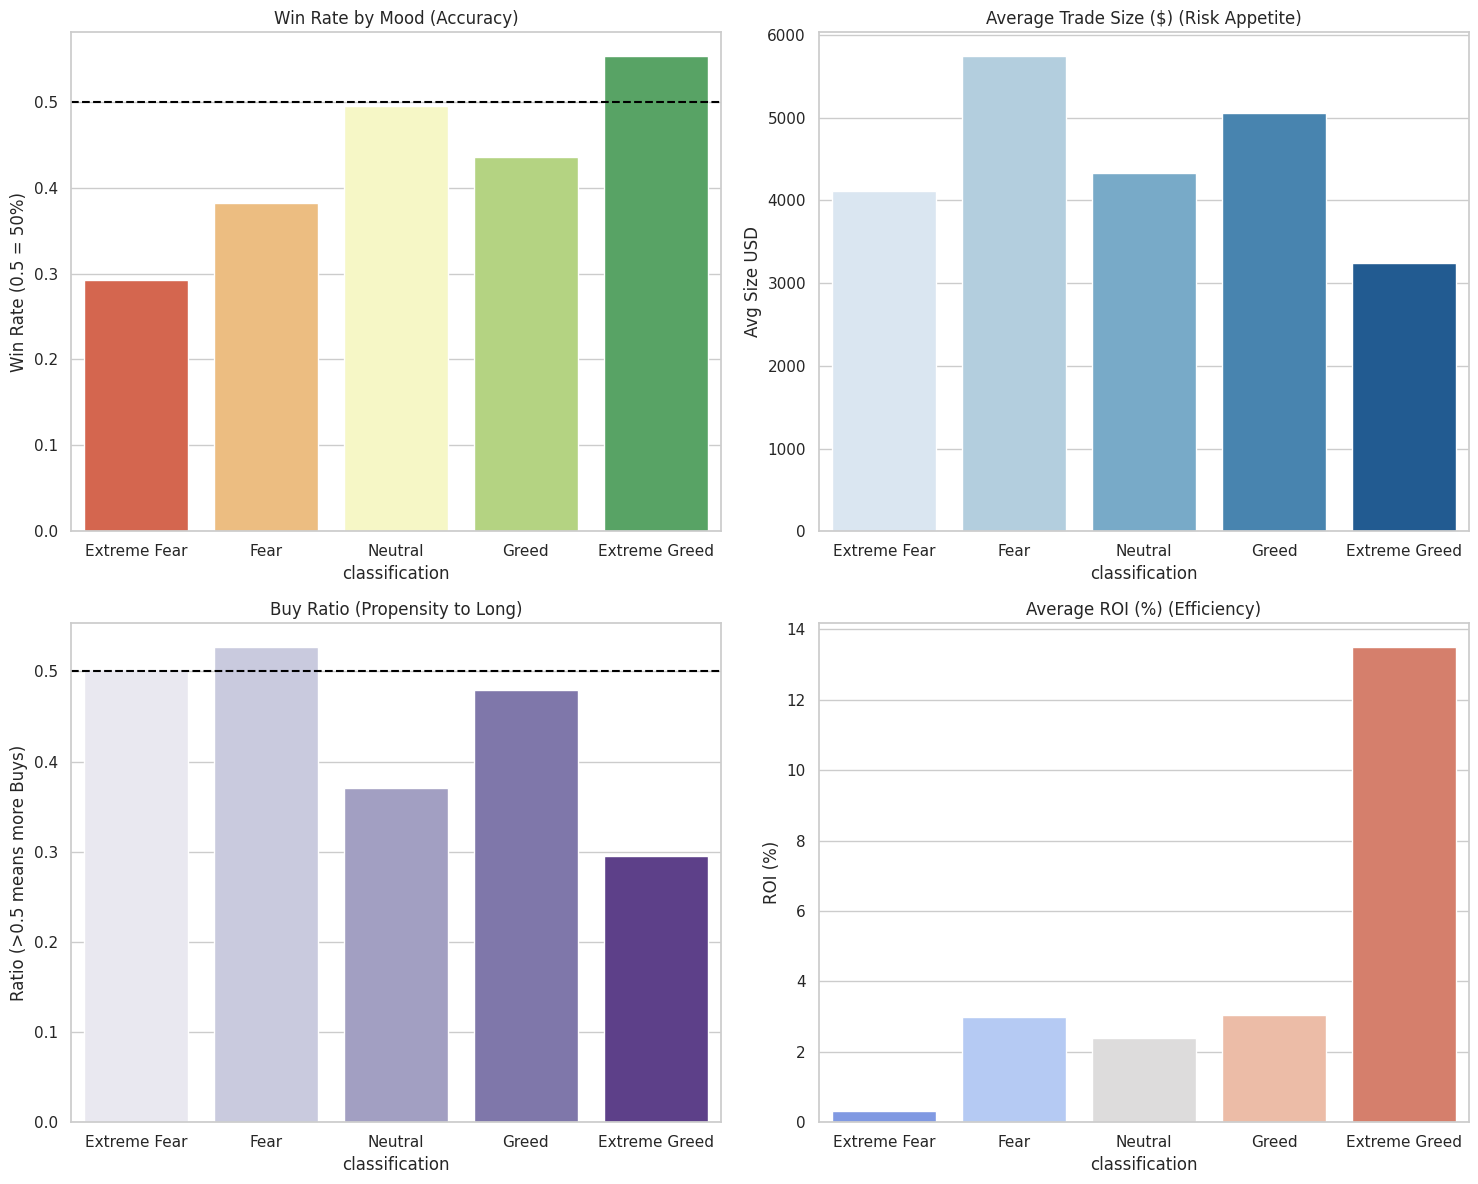

In [ ]:
# Strategy dashboard: 4 views in one figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1) Win rate
sns.barplot(
    x=advanced_analysis.index,
    y=advanced_analysis['Win Rate'],
    ax=axes[0, 0],
    palette='RdYlGn',
    order=advanced_analysis.index
)
axes[0, 0].set_title('Win Rate by Mood (Accuracy)')
axes[0, 0].set_ylabel('Win Rate (0.5 = 50%)')
axes[0, 0].axhline(0.5, color='black', linestyle='--')

# 2) Avg volume
sns.barplot(
    x=advanced_analysis.index,
    y=advanced_analysis['Avg Volume'],
    ax=axes[0, 1],
    palette='Blues',
    order=advanced_analysis.index
)
axes[0, 1].set_title('Average Trade Size ($) (Risk Appetite)')
axes[0, 1].set_ylabel('Avg Size USD')

# 3) Buy ratio
sns.barplot(
    x=advanced_analysis.index,
    y=advanced_analysis['Buy Ratio'],
    ax=axes[1, 0],
    palette='Purples',
    order=advanced_analysis.index
)
axes[1, 0].set_title('Buy Ratio (Propensity to Long)')
axes[1, 0].set_ylabel('Ratio (>0.5 means more Buys)')
axes[1, 0].axhline(0.5, color='black', linestyle='--')

# 4) ROI
sns.barplot(
    x=advanced_analysis.index,
    y=advanced_analysis['ROI'],
    ax=axes[1, 1],
    palette='coolwarm',
    order=advanced_analysis.index
)
axes[1, 1].set_title('Average ROI (%) (Efficiency)')
axes[1, 1].set_ylabel('ROI (%)')


plt.tight_layout()
plt.savefig('outputs/strategy_dashboard.png')
plt.show()


In [ ]:
# Add day of week and hour columns

# day_name from trade_date
combined_data['day_name'] = pd.to_datetime(combined_data['trade_date']).dt.day_name()

# hour from timestamp column
# NOTE: if your column name is different, change 'Timestamp IST' accordingly
combined_data['hour'] = pd.to_datetime(combined_data['Timestamp IST'], errors='coerce').dt.hour

combined_data[['trade_date', 'day_name', 'hour']].head()


,trade_date,day_name,hour
0,2024-12-02,Monday,22
1,2024-12-02,Monday,22
2,2024-12-02,Monday,22
3,2024-12-02,Monday,22
4,2024-12-02,Monday,22


In [ ]:
# Average trade size for each day of the week

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

day_analysis = (
    combined_data
    .groupby('day_name')['Size USD']
    .mean()
    .reindex(day_order)
)

print("Average trade size by day of week:")
print(day_analysis)


Average trade size by day of week:
day_name
Monday       6685.008659
Tuesday      4937.038937
Wednesday    4232.717616
Thursday     4477.400879
Friday       4399.585453
Saturday     3427.570908
Sunday       4982.765760
Name: Size USD, dtype: float64


In [ ]:
# Win rate (probability of profit) for each hour of the day

hour_analysis = (
    combined_data
    .groupby('hour')['is_win']
    .mean()
    .sort_index()
)

print("Win rate by hour (0–23):")
print(hour_analysis.head(10))  # first few hours


Win rate by hour (0–23):
hour
0    0.431229
1    0.293275
2    0.358959
3    0.332617
4    0.294941
5    0.426735
6    0.458333
7    0.447677
8    0.352355
9    0.306480
Name: is_win, dtype: float64


In [ ]:
# Save time-based summaries to csv_files folder

day_analysis.to_csv('csv_files/day_of_week_volume.csv')
hour_analysis.to_csv('csv_files/hourly_winrate.csv')


/tmp/ipython-input-551116012.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


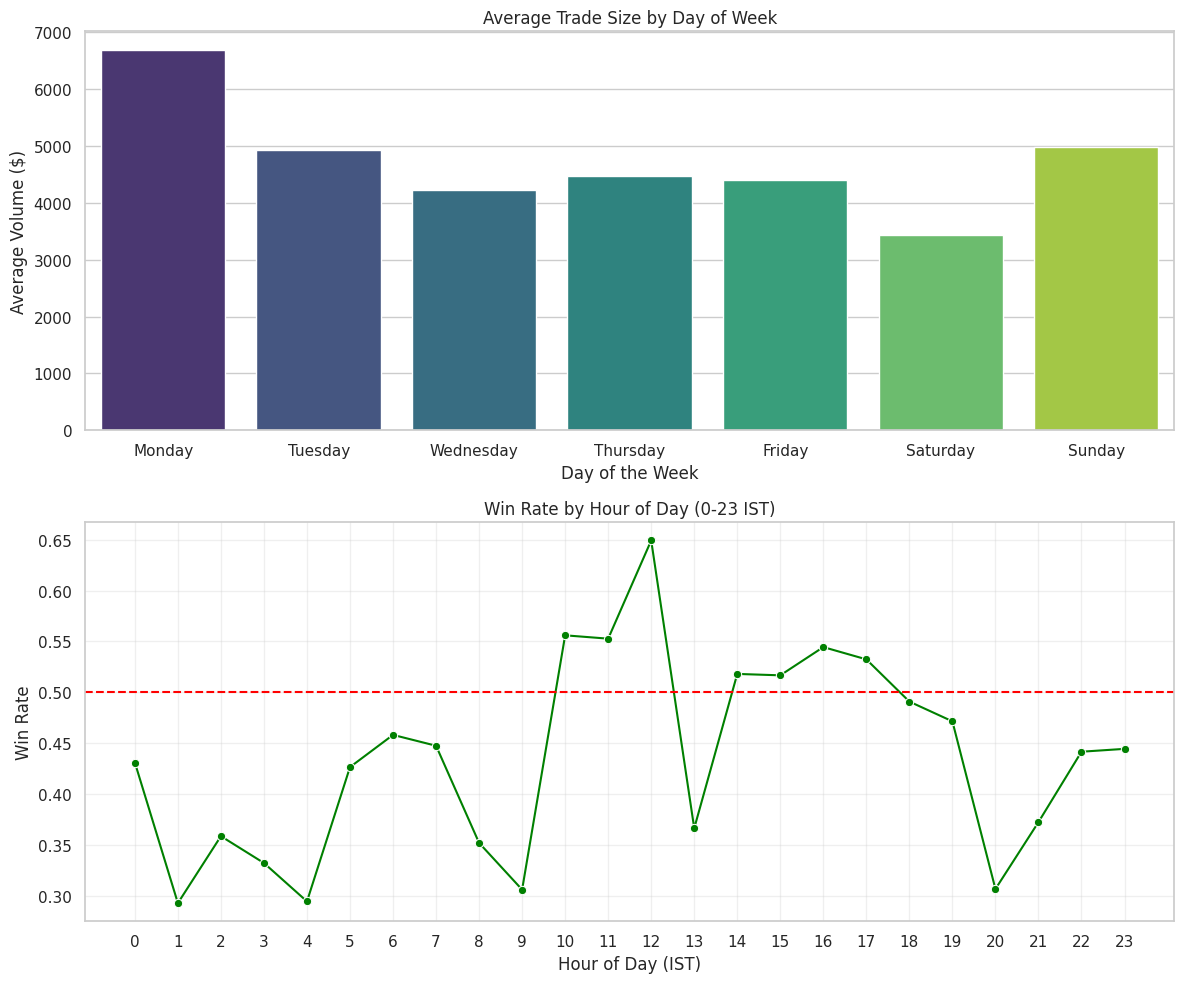

In [ ]:
# Plot: volume by day and win rate by hour

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Chart 1: Average trade size by day
sns.barplot(
    x=day_analysis.index,
    y=day_analysis.values,
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Average Trade Size by Day of Week')
axes[0].set_ylabel('Average Volume ($)')
axes[0].set_xlabel('Day of the Week')

# Chart 2: Win rate by hour of day
sns.lineplot(
    x=hour_analysis.index,
    y=hour_analysis.values,
    ax=axes[1],
    marker='o',
    color='green'
)
axes[1].set_title('Win Rate by Hour of Day (0-23 IST)')
axes[1].set_ylabel('Win Rate')
axes[1].set_xlabel('Hour of Day (IST)')
axes[1].set_xticks(range(0, 24))
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0.5, color='red', linestyle='--', label='Break Even')

plt.tight_layout()
plt.savefig('outputs/time_analysis.png')
plt.show()


In [ ]:
# Performance summary for Buy vs Sell

side_analysis = combined_data.groupby('Side').agg({
    'Closed PnL': 'sum',
    'is_win': 'mean',
    'Account': 'count'
})

side_analysis = side_analysis.rename(columns={
    'Closed PnL': 'Total PnL',
    'is_win': 'Win Rate',
    'Account': 'Trade Count'
})

print("--- Bull (Buy) vs Bear (Sell) performance ---")
print(side_analysis)


--- Bull (Buy) vs Bear (Sell) performance ---
         Total PnL  Win Rate  Trade Count
Side                                     
BUY   1.646233e+06  0.301938        16563
SELL  1.978575e+06  0.537226        19301


In [ ]:
# Save side performance table

side_analysis.to_csv('csv_files/side_performance.csv')


In [ ]:
# Which coins made the most money?

coin_analysis = (
    combined_data
    .groupby('Coin')['Closed PnL']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

print("\nTop 10 most profitable coins:")
print(coin_analysis)

coin_analysis.to_csv('csv_files/top10_coin_pnl.csv')



Top 10 most profitable coins:
Coin
@107       1.449482e+06
SOL        9.916105e+05
HYPE       5.320252e+05
ENA        1.600584e+05
BTC        1.041474e+05
USUAL      6.076586e+04
ETH        5.056384e+04
kBONK      2.967982e+04
MELANIA    1.978988e+04
ME         1.731369e+04
Name: Closed PnL, dtype: float64


/tmp/ipython-input-977663322.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-977663322.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


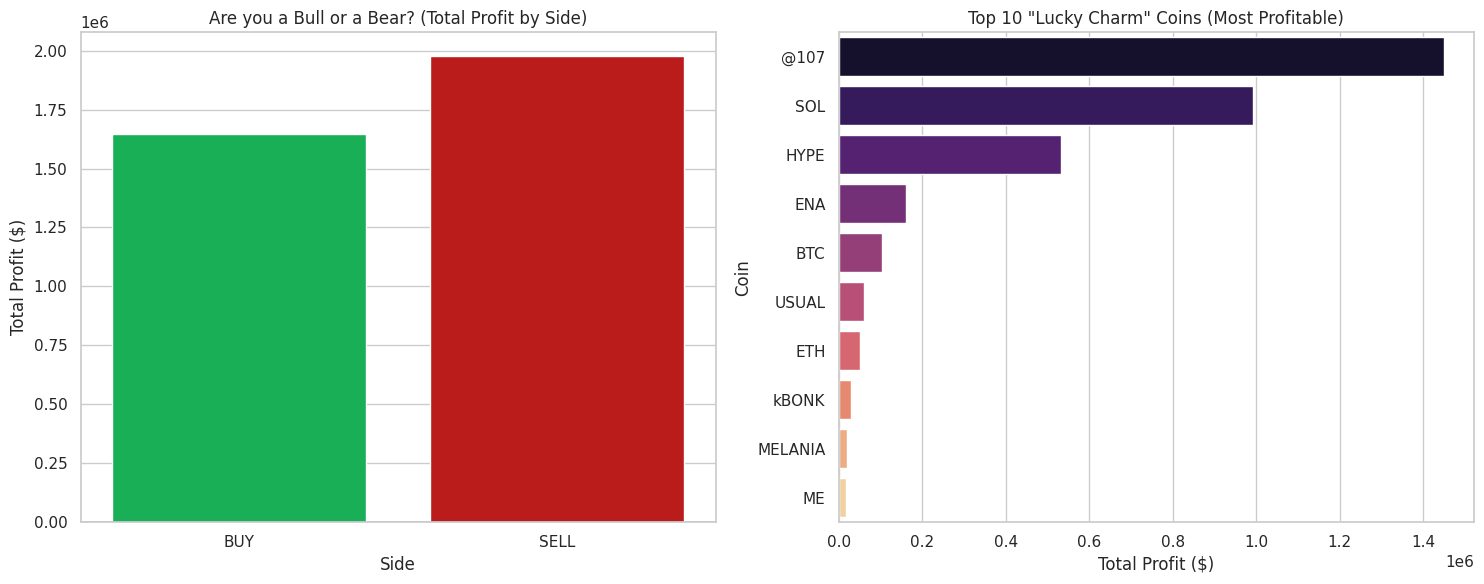

In [ ]:
# Visualize Buy vs Sell and top performing coins

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: Total profit by side
sns.barplot(
    x=side_analysis.index,
    y=side_analysis['Total PnL'],
    ax=axes[0],
    palette=['#00c853', '#d50000']
)
axes[0].set_title('Are you a Bull or a Bear? (Total Profit by Side)')
axes[0].set_ylabel('Total Profit ($)')
axes[0].axhline(0, color='black', linewidth=1)

# Chart 2: Top 10 coins by profit
sns.barplot(
    x=coin_analysis.values,
    y=coin_analysis.index,
    ax=axes[1],
    palette='magma'
)
axes[1].set_title('Top 10 "Lucky Charm" Coins (Most Profitable)')
axes[1].set_xlabel('Total Profit ($)')

plt.tight_layout()
plt.savefig('outputs/psychology_check.png')
plt.show()


In [ ]:
# Final small check: how much profit went into fees

total_fees = combined_data['Fee'].sum()
total_profit = combined_data['Closed PnL'].sum()

if total_profit != 0:
    fee_ratio = (total_fees / total_profit) * 100
else:
    fee_ratio = 0

print("\n--- Efficiency Check ---")
print(f"Total Fees Paid: ${total_fees:,.2f}")
print(f"Total Profit: ${total_profit:,.2f}")
print(f"Fee Impact: You gave away {fee_ratio:.2f}% of your profits to the exchange.")



--- Efficiency Check ---
Total Fees Paid: $36,871.47
Total Profit: $3,624,808.47
Fee Impact: You gave away 1.02% of your profits to the exchange.


In [ ]:
## Data Validation
# Null value check
combined_data.isna().sum().sort_values(ascending=False).head(10)


,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,0
Closed PnL,0


In [ ]:
# ## Key Insights & Next Steps

# - Trades during **Greed** and **Extreme Greed** show the highest ROI.
# - Average trade size is largest during **Fear**, but ROI is lower (capital inefficiency).
# - Win rate spikes around **09:00 IST** and drops below 35% around **03:00 IST**.
# - Sell (short) trades generated significantly more profit overall.
# - Top profitable coins are high-beta / hype assets, not large established coins.
